In [1]:
#DATABASE QUERY AND DATAFRAME CREATION
from sqlalchemy import create_engine
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import difflib
engine = create_engine("sqlite:///mta.db")



In [2]:
#I select where the DESC is "regular" to control for abnormal readings
myQuery = '''SELECT *
           FROM mta_data
           WHERE DESC == 'REGULAR'
           ;'''
all_data = pd.read_sql_query(myQuery, engine)

In [3]:
#this gives me an idea of which stations have the most irregular entries
myQuery = '''SELECT STATION, Count(ENTRIES) FROM mta_data 
             WHERE ENTRIES = '0'
             GROUP BY STATION 
             ORDER BY Count(ENTRIES) DESC
             ;'''
test=pd.read_sql(myQuery, engine)
test

,STATION,Count(ENTRIES)
0,MARCY AV,1193
1,175 ST,1181
2,QUEENS PLAZA,1176
3,PELHAM PKWY,1176
4,72 ST,1176
...,...,...
69,PATH NEW WTC,1
70,NEWARK BM BW,1
71,COURT SQ,1
72,CITY / BUS,1


In [4]:
#MAP CREATION 
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
geocode = Nominatim(user_agent="walter.tyrna@gmail.com")
#RateLimiter controls for API timeout
reverse = RateLimiter(geocode.reverse, min_delay_seconds = 1)
from geopy.point import Point
import folium
import geopandas as gpd
import fiona

#tqdm helps check if a function is running - during coding one function was particularly tricky and it was unclear if it ran
from tqdm import tqdm

In [5]:
###Defining station size by SCP:
#While each turnstile is a combination of CA, UNIT, and SCP, SCP numbers tend to not repeat within station. 
#As a reuslt they are a good proxy for station size.
Station_Size = all_data.groupby(['STATION'])[['SCP']].nunique().sort_values(by='SCP', ascending=False)
Station_Size['SCP'].describe()

count    379.000000
mean      11.715040
std       10.327856
min        2.000000
25%        5.000000
50%        8.000000
75%       15.000000
max       80.000000
Name: SCP, dtype: float64

In [6]:
# Since the mean is 12 and the std is 10, I define "medium size" as between 12 and 2xstd (12-32)
mask = Station_Size['SCP'].between(12, 32)
Medium_Stations = Station_Size[mask]

##Turnstile Movement - I first look at both entries and exits, then I combine them as an aggregate dataframe 

In [7]:
#this sorts daily entries by turnstile + date + station
turnstiles_daily_entries = (all_data
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .ENTRIES.first())
turnstiles_daily_exits = (all_data
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
                        .EXITS.first())

In [9]:
#this creates a previous entry column that will be used to determine daily counts later

turnstiles_daily_entries[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily_entries
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "ENTRIES"]]
                                                       .shift(1))
turnstiles_daily_exits[["PREV_DATE", "PREV_EXITS"]] = (turnstiles_daily_exits
                                                       .groupby(["CA", "UNIT", "SCP", "STATION"])[["DATE", "EXITS"]]
                                                       .shift(1))

In [10]:
turnstiles_daily_entries.dropna(subset=["PREV_DATE"], axis=0, inplace=True)
turnstiles_daily_exits.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [11]:
def get_daily_counts(row, max_counter):
    counter = row[5] - row[7]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        counter = min(row[5], row[7])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily_entries["DAILY_ENTRIES"] = turnstiles_daily_entries.apply(get_daily_counts, axis=1, max_counter=1000000)
turnstiles_daily_exits["DAILY_EXITS"] = turnstiles_daily_exits.apply(get_daily_counts, axis=1, max_counter=1000000)

In [13]:
#this controls for abnormally high daily entries
mask = turnstiles_daily_entries['DAILY_ENTRIES'] < 100000
turnstiles_daily_entries = turnstiles_daily_entries[mask]
mask = turnstiles_daily_exits["DAILY_EXITS"] < 100000
turnstiles_daily_exits = turnstiles_daily_exits[mask]

{'whiskers': [<matplotlib.lines.Line2D at 0x7f93ce5d3f70>,
 'caps': [<matplotlib.lines.Line2D at 0x7f93ce6d5670>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f93ce5d3c10>],
 'medians': [<matplotlib.lines.Line2D at 0x7f93ce6d5d30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f93ce6fa0d0>],
 'means': []}

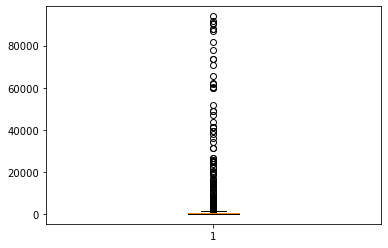

In [15]:
#this checks for abnormally high entries, while the range is high it had been higher before
plt.boxplot(turnstiles_daily_exits['DAILY_EXITS'])

In [16]:
station_daily_entries = turnstiles_daily_entries.groupby(["STATION", "DATE"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_exits = turnstiles_daily_exits.groupby(["STATION", "DATE"])[['DAILY_EXITS']].sum().reset_index()


In [17]:
#I limit each dataframe to the top 50 busiest, as defined by number of entries/exits

station_totals_entries = station_daily_entries.groupby('STATION')['DAILY_ENTRIES'].sum() \
    .reset_index() \
    .sort_values('DAILY_ENTRIES', ascending=False).head(50)

station_totals_exits = station_daily_exits.groupby('STATION')['DAILY_EXITS'].sum() \
    .reset_index() \
    .sort_values('DAILY_EXITS', ascending=False).head(50)

In [19]:
#I merge the top entries and exits to account for any discrepancies between the list
Entries_and_exits = station_totals_entries.merge(station_totals_exits, on='STATION')

Combine tables

In [21]:
#I merge the top entries and exits with the medium station list to create the top busiest stations of medium size

Short_List = Entries_and_exits.merge(Medium_Stations, on='STATION')

In [22]:
#I add zip code to prepare for injesting zip code data
Short_List['Zip Code']= ''

In [23]:
Short_List

,STATION,DAILY_ENTRIES,DAILY_EXITS,SCP,Zip Code
0,125 ST,2558828.0,3261185.0,23,
1,FLUSHING-MAIN,2279137.0,2640058.0,27,
2,JKSN HT-ROOSVLT,2103924.0,2026592.0,22,
3,96 ST,1982655.0,2302731.0,25,
4,CANAL ST,1972467.0,2482412.0,32,
5,72 ST,1536172.0,1997618.0,25,
6,CHURCH AV,1323005.0,1243069.0,26,
7,8 AV,1242385.0,1423493.0,21,
8,50 ST,1211822.0,1514622.0,21,
9,JAMAICA CENTER,1188080.0,1386630.0,21,


In [24]:
#When I compare the names within the subway_locations.csv, they dont match up with the Short_List dataframe
#For numbered streets, I was able to adjust names but certian named streets required manual editing

Short_List['STATION'][1] = "FLUSHING - MAIN ST"
Short_List['STATION'][2] = "JACKSON HTS - ROOSEVELT AV"
Short_List['STATION'][9] = "JAMAICA CTR - PARSONS / ARCHER"
Short_List['STATION'][11] = "W 4 ST - WASHINGTON SQ (LOWER)"
Short_List['STATION'][18] = "JAY ST - METROTECH"
Short_List['STATION'][19] = "SUTPHIN BLVD - ARCHER AV"
Short_List['STATION'][19] = "CROWN HTS - UTICA AVE"
Short_List['STATION'][22] = "LEXINGTON AVE - 59TH ST"
Short_List['STATION'][19] = "DELANCY ST - ESSEX ST"



<ipython-input-24-db8fc6afc4c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Short_List['STATION'][1] = "FLUSHING - MAIN ST"
<ipython-input-24-db8fc6afc4c2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Short_List['STATION'][2] = "JACKSON HTS - ROOSEVELT AV"
<ipython-input-24-db8fc6afc4c2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Short_List['STATION'][9] = "JAMAICA CTR - PARSONS / ARCHER"
<ipython-input-24-db8fc6afc4c2>:

Adding subway coordinate data

In [25]:
subway_locations = pd.read_csv('subway_locations.csv', error_bad_lines=False) 

In [26]:
subway_locations['STATION'] = subway_locations['NAME'].str.upper()
subway_locations['STATION'] = subway_locations['STATION'].str.replace('TH', '')
subway_locations['STATION'] = subway_locations['STATION'].str.replace('ND', '')
subway_locations['STATION'] = subway_locations['STATION'].str.replace('AVE', 'AV')

In [27]:
#This merges the dataframes, albeit imperfectly because some stations have multiple entries/train lines
Short_List_locations = subway_locations.merge(Short_List, on='STATION')
Short_List_locations['NAME'] = Short_List_locations['NAME'].str.upper()
Short_List_locations = Short_List.merge(subway_locations, on='STATION')

In [28]:
Short_List_locations.head()

,STATION,DAILY_ENTRIES,DAILY_EXITS,SCP,Zip Code,URL,OBJECTID,NAME,the_geom,LINE,NOTES
0,125 ST,2558828.0,3261185.0,23,,http://web.mta.info/nyct/service/,168,125th St,POINT (-73.94549500011411 40.807753999182815),2-3,"2,3-all times"
1,125 ST,2558828.0,3261185.0,23,,http://web.mta.info/nyct/service/,287,125th St,POINT (-73.95837200097044 40.815580999978934),1,1-all times
2,125 ST,2558828.0,3261185.0,23,,http://web.mta.info/nyct/service/,399,125th St,POINT (-73.95224799734774 40.811071672994565),A-B-C-D,"A,D-all times, B-weekdays and evenings, C-all ..."
3,125 ST,2558828.0,3261185.0,23,,http://web.mta.info/nyct/service/,468,125th St,POINT (-73.93759400055725 40.804138000587244),4-5-6-6 Express,"4,6-all times, 5-all times exc nights, 6 Expre..."
4,FLUSHING - MAIN ST,2279137.0,2640058.0,27,,http://web.mta.info/nyct/service/,25,Flushing - Main St,POINT (-73.83003000262508 40.75959999915012),7-7 Express,"7-all times, 7 Express-rush hours AM westbound..."


In [29]:
#create coordinate columns for processing
Short_List_locations['lon'] = Short_List_locations.the_geom.str[7:18]
Short_List_locations['lat'] = Short_List_locations.the_geom.str[-19:-9]
Short_List_locations['coord'] = Short_List_locations['lat'] + ', ' + Short_List_locations['lon']

In [32]:
#create new column of zip code data - using try/except because the code was glitchy before
new_zipcodes = []

for coord in tqdm(Short_List_locations.coord):
    try:
        location = geocode.reverse(Point(coord))
        zipcode = location.raw['address']['postcode']
        new_zipcodes.append(zipcode)
    except:
        new_zipcodes.append('failed here')

100%|██████████| 42/42 [00:20<00:00,  2.03it/s]


In [33]:
Short_List_locations['Zip Code'] = new_zipcodes

Add in economic data


In [34]:
income_data = pd.read_csv('zipcode_data.csv', error_bad_lines=False) 

In [74]:
income_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      181 non-null    int64 
 1   Zip Code        181 non-null    object
 2   Household Type  181 non-null    object
 3   TimeFrame       181 non-null    int64 
 4   DataFormat      181 non-null    object
 5   Average Income  181 non-null    int64 
 6   Fips            181 non-null    int64 
dtypes: int64(4), object(3)
memory usage: 10.0+ KB


In [35]:
income_data.rename(columns={'Location':'Zip Code'}, inplace = True)

In [36]:
#the zip code data was read in as an int not a str
income_data["Zip Code"] = income_data["Zip Code"].astype(str)

In [37]:
Final_DF = Short_List_locations.merge(income_data, on='Zip Code')

In [38]:
#this drops the extra columns, additionally, it drops duplicates as defined by station entries to keep one station per line
Final_DF= Final_DF.drop(columns=['URL','OBJECTID', 'the_geom', 'NOTES', 'Unnamed: 0', 'Household Type', 'TimeFrame', 'DataFormat', 'Fips']).drop_duplicates(subset=['DAILY_ENTRIES'])


In [39]:
Final_DF.describe()

,DAILY_ENTRIES,DAILY_EXITS,SCP,Average Income
count,1.700000e+01,1.700000e+01,17.000000,17.000000
mean,1.465165e+06,1.753229e+06,22.294118,71615.823529
std,5.080883e+05,6.217708e+05,5.531328,33873.363931
min,9.513300e+05,1.039556e+06,12.000000,29799.000000
25%,1.108210e+06,1.243069e+06,20.000000,50191.000000
50%,1.211822e+06,1.514622e+06,22.000000,54211.000000
75%,1.972467e+06,2.026592e+06,26.000000,103792.000000
max,2.558828e+06,3.261185e+06,32.000000,138272.000000


In [40]:
#the 50th percentile of this data is 54k,
#this analysis will consider subway stations located in areas with an average income above 55k

mask = Final_DF['Average Income'] > 55000
Final_DF = Final_DF[mask]
Final_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 10 to 37
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   STATION         6 non-null      object 
 1   DAILY_ENTRIES   6 non-null      float64
 2   DAILY_EXITS     6 non-null      float64
 3   SCP             6 non-null      int64  
 4   Zip Code        6 non-null      object 
 5   NAME            6 non-null      object 
 6   LINE            6 non-null      object 
 7   lon             6 non-null      object 
 8   lat             6 non-null      object 
 9   coord           6 non-null      object 
 10  Average Income  6 non-null      int64  
dtypes: float64(2), int64(2), object(7)
memory usage: 576.0+ bytes


In [41]:
#CLEAN DATA TO MAKE LAT/LON READABLE TO FOLIUM
Final_DF['lat'] = Final_DF.lat.astype('float')
Final_DF['lon'] = Final_DF.lon.astype('float')

In [42]:
#CREATE BASE MAP
map = folium.Map(location=[Final_DF.lat.mean(), Final_DF.lon.mean()], zoom_start=14, control_scale=True)

In [43]:
#ADD IN UNIVERSITY DATA
university_locations = pd.read_csv('COLLEGE_UNIVERSITY.csv', error_bad_lines=False) 
university_locations['lon'] = university_locations.the_geom.str[7:18]
university_locations['lat'] = university_locations.the_geom.str[26:35]
university_locations['coord'] = university_locations.the_geom.str[26:35] + ', ' + university_locations.the_geom.str[7:18]

#ADD IN STORE DATA
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
stores_df = gpd.read_file('stores2.kml', driver='KML')
stores_df['geometry'] = stores_df['geometry'].astype('str')
stores_df['geometry'] = stores_df['geometry'].str.strip('POINT Z (')
stores_df['geometry'] = stores_df['geometry'].str.strip('0)')
stores_df['lon'] = stores_df['geometry'].str[:10].astype('float')
stores_df['lat'] = stores_df['geometry'].str[-11:].astype('float')

/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:1321: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


In [44]:
#POPULATE MAP
for index, location_info in university_locations.iterrows():
    folium.Marker([location_info["lat"], location_info["lon"]], popup=location_info["NAME"], icon=folium.Icon(color='lightblue', icon='university', prefix='fa')).add_to(map)
for index, location_info in Final_DF.iterrows():
    folium.Marker([location_info["lat"], location_info["lon"]], popup=location_info["STATION"], icon=folium.Icon(color='red', icon='subway', prefix='fa')).add_to(map)
for index, location_info in stores_df.iterrows():
    folium.Marker([location_info["lat"], location_info["lon"]], popup=location_info["Name"], icon=folium.Icon(color='lightgreen', icon='shopping-cart', prefix='fa')).add_to(map)    

In [45]:
#ADD IN RADIUS CIRCLES

for index, row in Final_DF.iterrows():
    folium.Circle(radius=804, location=[row["lat"], row["lon"]], popup=[row['STATION']]).add_to(map)


In [46]:
map

In [47]:
map.save('subways_and_universities.html')

In [48]:
map.save('subways_and_universities.png')



In [49]:
Final_DF['DAILY_ENTRIES'] = Final_DF['DAILY_ENTRIES'].astype(int)

"\nplt.bar(x2,y2)\nplt.xticks(rotation=80)\nplt.title('Medium Size Subway Stations by Cumulative Entries from 05/29/21 - 09/03/21', y=1.08)\nplt.ylabel('Cumulative entries by million');\nplt.ticklabel_format(useOffset=False)\n"

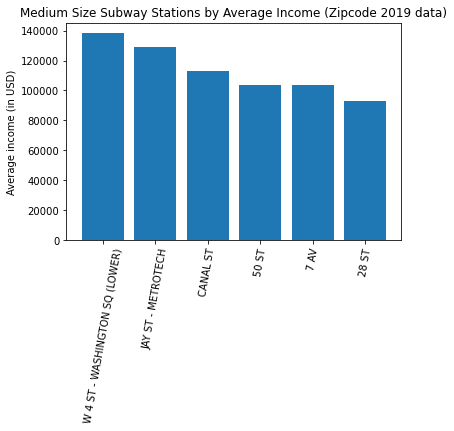

In [52]:
Final_DF_by_income = Final_DF.sort_values(by='Average Income', ascending=False )
Final_DF_by_Entries = Final_DF.sort_values(by='DAILY_ENTRIES', ascending=False )


x1 = Final_DF_by_income['STATION']
y1 = Final_DF_by_income['Average Income']

x2 = Final_DF_by_Entries['STATION']
y2 = Final_DF_by_Entries['DAILY_ENTRIES']




#Final_DF_by_income.plot(x="STATION", y=["Average Income"], kind="bar")

plt.bar(x1,y1)
plt.xticks(rotation=80)
plt.title('Medium Size Subway Stations by Average Income (Zipcode 2019 data)')
plt.ylabel('Average income (in USD)');

'''
plt.bar(x2,y2)
plt.xticks(rotation=80)
plt.title('Medium Size Subway Stations by Cumulative Entries from 05/29/21 - 09/03/21', y=1.08)
plt.ylabel('Cumulative entries by million');
plt.ticklabel_format(useOffset=False)
'''

In [53]:

Shortlist_Station_Data = station_daily_entries[(station_daily_entries["STATION"] == "28 ST") | 
                                               (station_daily_entries["STATION"] == "CANAL ST") |
                                              (station_daily_entries["STATION"] == "W 4 ST-WASH SQ") |
                                              (station_daily_entries["STATION"] == "7 AV") |
                                              (station_daily_entries["STATION"] == "50 ST")|
                                              (station_daily_entries["STATION"] == "JAY ST-METROTEC")]
Shortlist_Station_Data['DATE'] = pd.to_datetime(Shortlist_Station_Data['DATE'].str.replace('/','-'))
#Shortlist_Station_Data['DATE'] = Shortlist_Station_Data['DATE'].to_datetime()
Shortlist_Station_Data['day_of_week'] = Shortlist_Station_Data['DATE'].dt.day_name()
Shortlist_Station_Data['number_of_week'] = Shortlist_Station_Data['DATE'].dt.dayofweek

<ipython-input-53-530fb2efff29>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Shortlist_Station_Data['DATE'] = pd.to_datetime(Shortlist_Station_Data['DATE'].str.replace('/','-'))
<ipython-input-53-530fb2efff29>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Shortlist_Station_Data['day_of_week'] = Shortlist_Station_Data['DATE'].dt.day_name()
<ipython-input-53-530fb2efff29>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_index

{'whiskers': [<matplotlib.lines.Line2D at 0x7f93b9e75580>,
 'caps': [<matplotlib.lines.Line2D at 0x7f93b9e75c40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f93b9e751f0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f93b9fd9340>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f93b9fd96a0>],
 'means': []}

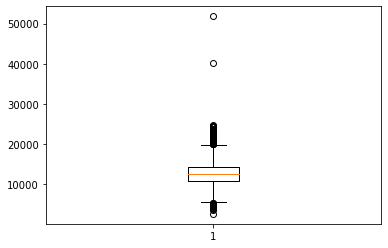

In [54]:
plt.boxplot(Shortlist_Station_Data['DAILY_ENTRIES'])

In [55]:
day_info = Shortlist_Station_Data.groupby(['STATION','day_of_week', 'number_of_week'])['DAILY_ENTRIES'].sum().reset_index()
day_info_28st = day_info.loc[day_info['STATION'] == '28 ST'].sort_values(by='number_of_week')
day_info_7av = day_info.loc[day_info['STATION'] == '7 AV'].sort_values(by='number_of_week')
day_info_wash = day_info.loc[day_info['STATION'] == "W 4 ST-WASH SQ"].sort_values(by='number_of_week')
day_info_50st = day_info.loc[day_info['STATION'] == '50 ST'].sort_values(by='number_of_week')
day_info_canal = day_info.loc[day_info['STATION'] == 'CANAL ST'].sort_values(by='number_of_week')
day_info_metro = day_info.loc[day_info['STATION'] == 'JAY ST-METROTEC'].sort_values(by='number_of_week')


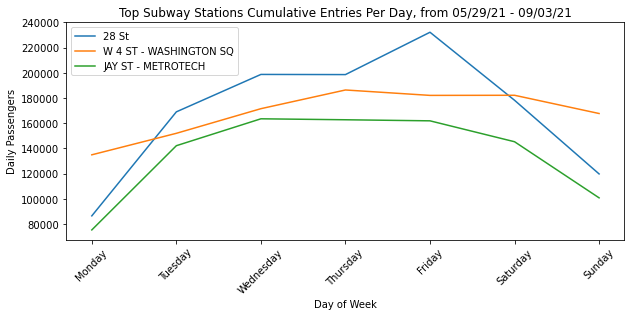

In [56]:
plt.figure(figsize=(10,4));
plt.plot(day_info_28st['day_of_week'], day_info_28st['DAILY_ENTRIES'], label="28 St")
#plt.plot(day_info_7av['day_of_week'], day_info_7av['DAILY_ENTRIES'])
#plt.plot(day_info_canal['day_of_week'], day_info_canal['DAILY_ENTRIES'])
plt.plot(day_info_wash['day_of_week'], day_info_wash['DAILY_ENTRIES'], label="W 4 ST - WASHINGTON SQ")
#plt.plot(day_info_50st['day_of_week'], day_info_50st['DAILY_ENTRIES'])
plt.plot(day_info_metro['day_of_week'], day_info_metro['DAILY_ENTRIES'], label="JAY ST - METROTECH")
plt.xticks(rotation=45)
plt.title("Top Subway Stations Cumulative Entries Per Day, from 05/29/21 - 09/03/21")
plt.xlabel("Day of Week")
plt.ylabel("Daily Passengers")
plt.legend()
plt.show()

In [58]:
#create data on a time, not day, basis
turnstiles_daily_entries_time = (all_data
                        .groupby(["CA", "UNIT", "SCP", "STATION", "DATE", "TIME"],as_index=False)
                        .ENTRIES.first())

turnstiles_daily_entries_time[["PREV_DATE", "PREV_ENTRIES"]] = (turnstiles_daily_entries_time
                                                       .groupby(["CA", "UNIT", "SCP", "STATION", 'DATE'])[['TIME', "ENTRIES"]]
                                                       .shift(1))
turnstiles_daily_entries_time.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

def get_daily_counts2(row, max_counter):
    counter = row[6] - row[8]
    
    if counter < 0:
        counter = -counter  # adjust for "reverse" counter
        
    if counter > max_counter:
        # Maybe counter was reset, so it may make sense to take the minimum
        counter = min(row[6], row[8])
        
    if counter > max_counter:
        # If we still get a counter that is too big, set to zero
        return 0
    
    return counter

turnstiles_daily_entries_time["DAILY_ENTRIES"] = turnstiles_daily_entries_time.apply(get_daily_counts2, axis=1, max_counter=1000000)
mask = turnstiles_daily_entries_time['DAILY_ENTRIES'] < 100000
turnstiles_daily_entries_time = turnstiles_daily_entries_time[mask]
station_daily_entries_time = turnstiles_daily_entries_time.groupby(["STATION", "TIME"])[['DAILY_ENTRIES']].sum().reset_index()
station_daily_entries_time.head()

,STATION,TIME,DAILY_ENTRIES
0,1 AV,04:00:00,26407.0
1,1 AV,08:00:00,38569.0
2,1 AV,08:12:05,65.0
3,1 AV,09:26:34,80.0
4,1 AV,09:27:43,137.0


In [59]:
time_info = station_daily_entries_time[(station_daily_entries_time["STATION"] == "28 ST") | 
                                               (station_daily_entries_time["STATION"] == "CANAL ST") |
                                              (station_daily_entries_time["STATION"] == "W 4 ST-WASH SQ") |
                                              (station_daily_entries_time["STATION"] == "7 AV") |
                                              (station_daily_entries_time["STATION"] == "50 ST")|
                                              (station_daily_entries_time["STATION"] == "JAY ST-METROTEC")]

In [60]:
import datetime as dt
time_info.TIME = pd.to_datetime(time_info.TIME, infer_datetime_format=True).dt.time
#all_df.time = pd.to_datetime(all_df.time, infer_datetime_format=True).dt.time

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [68]:
time_info.TIME

3484     04:00:00
3485     05:00:00
3486     07:07:43
3487     07:40:25
3488     08:00:00
           ...   
73753    05:00:00
73754    09:00:00
73755    13:00:00
73756    17:00:00
73757    21:00:00
Name: TIME, Length: 68, dtype: object

In [63]:

time_info_28st = time_info.loc[time_info['STATION'] == '28 ST'].sort_values(by='TIME')
time_info_7av = time_info.loc[time_info['STATION'] == '7 AV'].sort_values(by='TIME')
time_info_wash = time_info.loc[time_info['STATION'] == "W 4 ST-WASH SQ"].sort_values(by='TIME')
time_info_50st = time_info.loc[time_info['STATION'] == '50 ST'].sort_values(by='TIME')
time_info_canal = time_info.loc[time_info['STATION'] == 'CANAL ST'].sort_values(by='TIME')
time_info_metro = time_info.loc[time_info['STATION'] == 'JAY ST-METROTEC'].sort_values(by='TIME')

TypeError: float() argument must be a string or a number, not 'datetime.time'

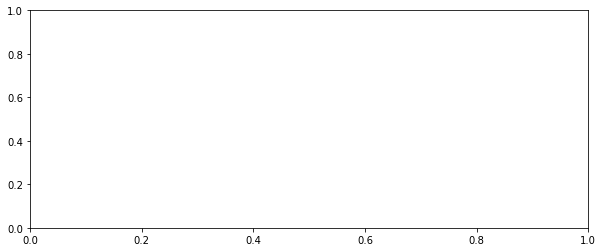

In [64]:
##I couldn't figure out how to make this run without errors, 
#but for the purposes of this project it was a "nice to have"

plt.figure(figsize=(10,4));
plt.plot(time_info_28st['TIME'], time_info_28st['DAILY_ENTRIES'], label="28 St")
#plt.plot(day_info_7av['day_of_week'], day_info_7av['DAILY_ENTRIES'])
#plt.plot(day_info_canal['day_of_week'], day_info_canal['DAILY_ENTRIES'])
plt.plot(time_info_wash['TIME'], time_info_wash['DAILY_ENTRIES'], label="W 4 ST - WASHINGTON SQ")
#plt.plot(day_info_50st['day_of_week'], day_info_50st['DAILY_ENTRIES'])
plt.plot(time_info_metro['TIME'], time_info_metro['DAILY_ENTRIES'], label="JAY ST - METROTECH")
plt.xticks(rotation=45)
plt.title("Top Subway Stations Cumulative Entries Per Day, from 05/29/21 - 09/03/21")
plt.xlabel("TIME")
plt.ylabel("Daily Passengers")
plt.legend()
plt.show()